<a href="https://colab.research.google.com/github/OdysseusPolymetis/initiation_programmation/blob/main/4_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/OdysseusPolymetis/initiation_programmation.git

In [ ]:
!unzip '/content/initiation_programmation/auteurs.zip'

In [16]:
import os
import xml.etree.ElementTree as ET
import string

In [17]:
stopwords = open("/content/initiation_programmation/stopwords_fr.txt",'r',encoding="utf8").read().split("\n")

In [18]:
len(stopwords)

717

In [19]:
french_dir = '/content/auteurs/verne'

In [20]:
def process_gold_directory(directory):
    all_sentences = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            sentences = parse_treebank_file(file_path)

            for sentence in sentences:
                all_sentences.append(sentence)

                #print(f"Processed {file_path}")

    return all_sentences

In [21]:
def parse_treebank_file(file_path):

    namespaces = {
        'tei': 'http://www.tei-c.org/ns/1.0',
        'x': 'http://www.atilf.fr/allegro'
    }

    tree = ET.parse(file_path)
    root = tree.getroot()

    indexed_gold_sentences = []
    file_id1 = os.path.basename(file_path)

    for i, sentence in enumerate(root.findall('.//tei:p', namespaces)):
        words = []
        for word in sentence.findall('.//x:wf', namespaces):
          word_text = word.get('word')
          lemma_text = word.get('lemma')
          if not any(entity in word_text or entity in lemma_text for entity in ['&quot;', '&amp;quot;']):
                words.append({
                    'form': word_text,
                    'lemma': lemma_text,
                    'pos': word.get('pos')
                })
        indexed_gold_sentences.append(words)
    return indexed_gold_sentences

In [22]:
treebank_sentences=process_gold_directory(french_dir)

In [103]:
forms=[]
lemmas=[]
no_stop=[]

for sentence in treebank_sentences:
  for word in sentence:
    if word["form"] not in string.punctuation and word["lemma"] not in stopwords:
      if word["lemma"] is not None:
        lemmas.append(word["lemma"])
        no_stop.append(word["lemma"])
      forms.append(word["form"])
    elif word["form"] not in string.punctuation:
      if word["lemma"] is not None:
        lemmas.append(word["lemma"])
      forms.append(word["form"])

In [104]:
len(lemmas)

1079821

In [105]:
len(forms)

1079821

In [106]:
len(no_stop)

437882

##Le TAL, qu'est-ce, et pourquoi ?
En termes généraux, beaucoup de gens ont recours au TAL pour la phase de prétraitement. Et c'est un passage bien souvent nécessaire si vous voulez éviter le pbruit dans les données, notamment sur le plan fréquentiel.
<br>Ici nous allons voir un exemple d'analyse fréquentielle avec et sans prétraitement.

Imaginons que nous voulions créer un nuage de mots pour représenter un texte particulier.
<br>Ici nous allons nous concentrer sur toutes les oeuvres de Jules Verne (mais vous pouvez en choisir un autre) en même temps, en les prenant sur Frantext.

In [49]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

def create_word_cloud(words_list, title):
    text = ' '.join(words_list)

    radius = 495
    diameter = radius * 2
    center = radius
    x, y = np.ogrid[:diameter, :diameter]
    mask = (x - center) ** 2 + (y - center) ** 2 > radius ** 2
    mask = 255 * mask.astype(int)

    mask_rgba = np.dstack((mask, mask, mask, 255 - mask))

    wordcloud = WordCloud(repeat=False, width=diameter, height=diameter,
                          background_color=None, mode="RGBA", colormap='plasma',
                          mask=mask_rgba).generate(text)

    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

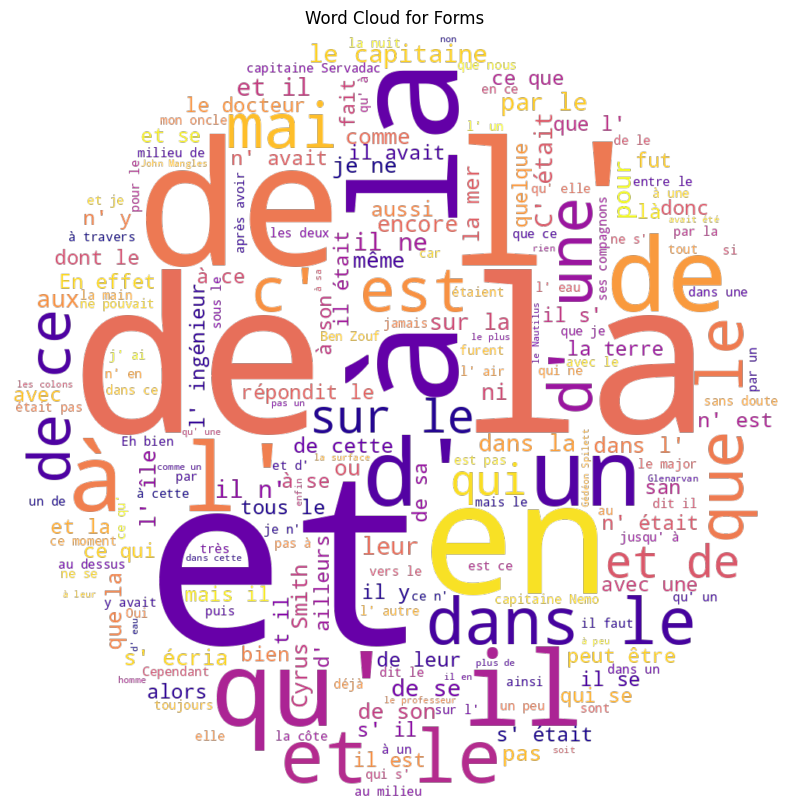

In [50]:
create_word_cloud(forms, 'Word Cloud for Forms')

Ce nuage ne sert pas à grand chose. Pourquoi ? Parce qu'il nous permet simplement de dire que le grec contient bon nombre de mots outils. Et sauf dans le cas d'une analyse stylistique, pour une représentation graphique, cela n'a guère de poids. Par ailleurs, bon nombre de mots sont encore sous leur forme flexionnelle : on a donc autant d'occurrences que de mots conjugués par exemple.
<br>Donc, **lemmatisons**.

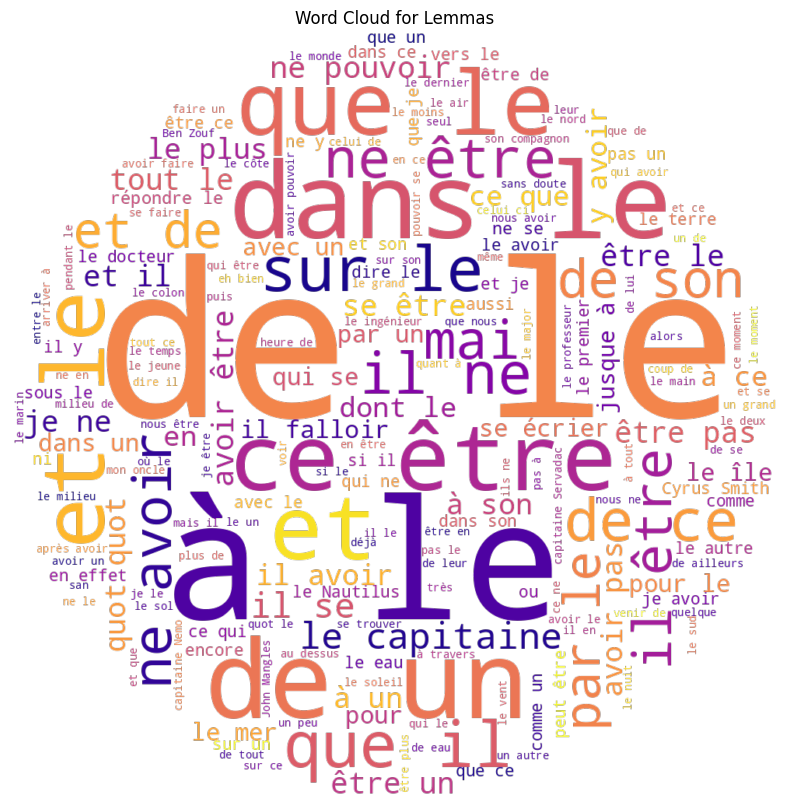

In [51]:
create_word_cloud(lemmas, 'Word Cloud for Lemmas')

Ça n'est pas beaucoup mieux, mais c'est mieux. Certains termes commencent à émerger.
<br>Cette fois, enlevons les **mots-outils**, et la ponctuation.

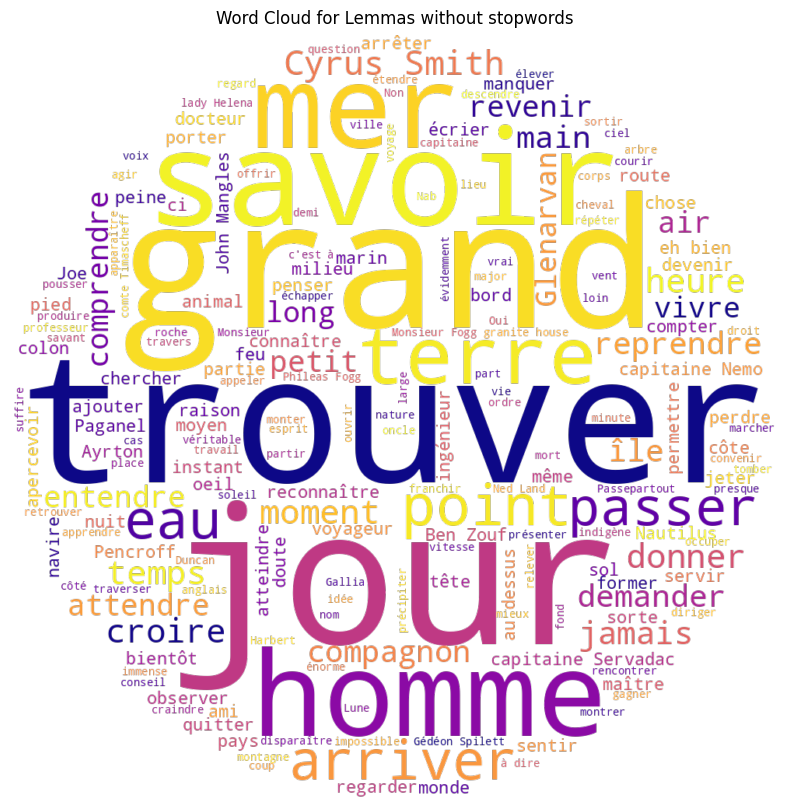

In [107]:
create_word_cloud(no_stop, 'Word Cloud for Lemmas without stopwords')

Clairement il s'agit d'un nuage beaucoup plus satisfaisant désormais.

#**TOKÉNISER, LEMMATISER, POSTAGGER**

Maintenant essayons **`stanza`**.
<br>Nous allons reprendre l'_Avare_. Il est déjà présent dans le github que vous avez téléchargé au début de ce notebook.

In [ ]:
!pip install stanza

In [5]:
filepath_of_text = "/content/initiation_programmation/l_avare.txt"

In [6]:
full_text = open(filepath_of_text, encoding="utf-8").read()

##**stanza**

J'utilise généralement `stanza` pour trois raisons :
<br>- il y a un très grand nombre de langues traitées (Vous pouvez les consulter [ici](https://stanfordnlp.github.io/stanza/performance.html)),
<br>- c'est très rapide et ça fait un excellent usage de la GPU,
<br>- c'est facile à implémenter.

Pour télécharger des modèles spécifiques dans `stanza`, vous devrez rentrer les codes lettres des langues, que vous trouverez [ici](https://stanfordnlp.github.io/stanza/performance.html).
<br>Commençons avec le modèle français par défaut.

In [2]:
import stanza
stanza.download('fr')

INFO:stanza:Downloading default packages for language: fr (French) ...
INFO:stanza:File exists: /root/stanza_resources/fr/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources.


Beaucoup de modèles ont beaucoup de processus embarqués, et sont trop lourds. Je vous recommande d'être plus sélectifs lors de l'instanciation des processus. Vous pouvez le faire de cette manière :

In [3]:
nlp_stanza = stanza.Pipeline(lang='fr', processors='tokenize,mwt,pos,lemma')

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: fr (French):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


In [10]:
def batch_process(text, nlp, batch_size=50):
    paragraphs = text.split('\n')
    batches = [paragraphs[i:i + batch_size] for i in range(0, len(paragraphs), batch_size)]

    words = []

    for batch in batches:
        batch_text = '\n'.join(batch)
        doc = nlp(batch_text)
        for sentence in doc.sentences:
            for word in sentence.words:
                token={}
                if word.lemma is not None:
                    token["word"]=word.text
                    token["lemma"]=word.lemma
                    token["pos"]=word.pos
                    words.append(token)

    return words

In [11]:
avare_analyzed = batch_process(full_text, nlp_stanza)

In [13]:
print(avare_analyzed[5:10])

[{'word': 'Valère', 'lemma': 'Valère', 'pos': 'PROPN'}, {'word': '-', 'lemma': '-', 'pos': 'PUNCT'}, {'word': 'Hé', 'lemma': 'hé', 'pos': 'INTJ'}, {'word': 'quoi', 'lemma': 'quoi', 'pos': 'INTJ'}, {'word': '!', 'lemma': '!', 'pos': 'PUNCT'}]


## Les word embeddings

D'abord on va récupérer le traitement qu'on avait fait plus haut sur les textes de Verne. On va simplement retenir des listes de phrases, qui sont elles-mêmes des listes de mots.

In [15]:
def convert_to_lemmas_sentences(indexed_gold_sentences):
    lemmas_sentences = []

    for sentence in indexed_gold_sentences:
        lemmas = [word['lemma'] for word in sentence if 'lemma' in word]
        lemmas_sentences.append(lemmas)

    return lemmas_sentences

In [23]:
lemmas_sentences = convert_to_lemmas_sentences(treebank_sentences)

In [24]:
len(lemmas_sentences)

13080

On va ensuite importer un vectoriseur. Ici Word2vec.

In [25]:
from gensim.models import Word2Vec

In [26]:
model = Word2Vec(lemmas_sentences, min_count=2, max_vocab_size=10000, negative=10, epochs=100)

In [27]:
model.wv.save("/content/model_verne.bin")

In [28]:
#Paris is to France what London is to what ? model.wv.most_similar(positive=['Londres', 'France'], negative=['Paris'],topn=5)
#King is to man what Queen is to what ? model.wv.most_similar(positive=['reine', 'homme'], negative=['roi'],topn=5)
model.wv.most_similar(positive=['reine', 'homme'], negative=['roi'],topn=10)

[('fille', 0.36764246225357056),
 ('chasseur', 0.33732298016548157),
 ('cheik', 0.334103524684906),
 ('prêtre', 0.3125336468219757),
 ('coupable', 0.31159070134162903),
 ('Rotzko', 0.30896350741386414),
 ('Bénarès', 0.30366063117980957),
 ('congé', 0.29862892627716064),
 ('momentanément', 0.2953673005104065),
 ('souvent', 0.2943698763847351)]

In [29]:
model.wv.most_similar('esprit',topn=10)

[('imagination', 0.6486831903457642),
 ('cerveau', 0.6210289001464844),
 ('idée', 0.5279174447059631),
 ('pensée', 0.5175565481185913),
 ('souvenir', 0.5048524737358093),
 ('rêve', 0.49849942326545715),
 ('théorie', 0.4883378744125366),
 ('situation', 0.4675294756889343),
 ('projet', 0.45948418974876404),
 ('réflexion', 0.4403643310070038)]

Et pour une visualisation plus globale de vos résultats, vous pouvez utiliser les fichiers que nous générons ci-dessous dans [tensorflow](https://projector.tensorflow.org/).

In [32]:
with open('/content/tensorflow.tsv', 'w+') as tensors:
    with open( '/content/tensorflowmeta.tsv', 'w+') as metadata:
         for word in model.wv.index_to_key:
                metadata.write(word+'\n')
                vector_row = '\t'.join(map(str, model.wv[word]))
                tensors.write(vector_row + '\n')